In [117]:
import os
import sys
import glob
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd

from tqdm import tqdm

sys.path.append('../src/')

from constants import set_latex_font

# Load Data

In [118]:
def dict_from_path(path):
    def to_float(val):
        try:
            val = float(val)
        except:
            pass
        return val
    
    p = path
    p = os.path.basename(p)
    p = os.path.splitext(p)[0]
    sp = p.split(',')
    d1 = dict([s.split('-') for s in sp][:-1])


    d2 = {k: to_float(v) for k, v in d1.items()}
    return d2

def df_str_2_arr(df):
    """
    Saving a dataframe containing arrays
    makes it such that when using read_csv()
    The arrays are read in as strings [1 2 3]
    To fix this we apply the following solution
    """
    def makeArray(text):
        text = text.replace('[', '')
        text = text.replace(']', '')
        return np.fromstring(text,sep=' ')


    for col in df.columns:
        df[col] = df[col].apply(makeArray)
    return df

In [119]:
csv_paths = glob.glob('../data/MC/*.csv')

# Split files ending in _erass and _count
csv_erass = []
csv_counts = []

for csv in csv_paths:
    if 'erass' in csv:
        csv_erass.append(csv)
    elif 'counts' in csv:
        csv_counts.append(csv)
    else:
        print(f'Unexpected csv path: {csv}')


# Dataframe to hold all data
def load_csvs(csv_paths):
    df2 = pd.DataFrame()

    for csv in tqdm(csv_paths):
        d = dict_from_path(csv) # Create parameter dict from filename
        df = pd.read_csv(csv)   # Read csv file
        for k, v in d.items():  # Add parameters to df
            df[k] = v

        df2 = df2.append(df) # Append to master df
    return df2

# Result dfs
df_counts = load_csvs(csv_counts)
df_erass  = load_csvs(csv_erass)

100%|██████████| 320/320 [02:17<00:00,  2.33it/s]


# Simulation grid / dictionary

In [120]:
grid_mc = {'N_mc'      : [10000],
           'N_sys'     : [500],
           'Z'         : ['all', 0.02, 0.002, 0.0002],
           'bh_ratio'  : [0.0, 0.25, 0.5, 0.75, 1.00],
           'dincl_max' : [46, 21],
           'period'    : ['P_wind_days', 'P_sup_days'],
           'duty_cycle': [1.0, 0.2]}

# In Python versions earlier than 3.6 the
# order of the grid_params may not be consistent here.
grid_params   = list(grid_mc.keys())                 # list of 'str' containing param names
grid_N_params = len(grid_mc)                         # Number of parameters
grid_iterations = sum([len(i) for i in grid_mc.values()]) # number of grid iterations
grid_product  = product(*grid_mc.values()) # Gridsearch Iterator

# Calculate Additional quantities / Cleanup

In [121]:
# of potentially visible systems
df_counts['N_alive_tot_and_transient'] = df_counts['N_alive_tot'] + df_counts['N_transient']

# % of N_sys
df_counts['frac_alive_tot'] = df_counts['N_alive_tot'] / df_counts['N_sys']
df_counts['frac_transient'] = df_counts['N_transient'] / df_counts['N_sys']
df_counts['frac_dead'] = df_counts['N_dead'] / df_counts['N_sys']

# % of visible
df_counts['frac_alive_visible'] = df_counts['N_alive_tot'] / df_counts['N_alive_tot_and_transient']
df_counts['frac_trans_visible'] = df_counts['N_transient'] / df_counts['N_alive_tot_and_transient']


In [122]:
gb_counts = df_counts.groupby(grid_params).agg(['mean', 'std'])
df_counts = df_counts.set_index(grid_params)
df_erass  = df_erass.set_index(grid_params)
df_erass  = df_str_2_arr(df_erass) #Convert strings to arrays

df_res = pd.concat([df_counts, df_erass], axis=1) #Combine all results into one dataframe

#df_res = 
# Subsets may be accessed via gb.loc[N_mc,N_sys,Z,bh_ratio,dincl_max,period,duty_cycle]
# example get Z = 0.02 --> gb.loc[:,:,0.02]
#gb_counts.loc[1000,500,0.02,:,46,'P_wind_days',1.0]

In [123]:
# Total number of observed systems (erass)
df_res['N_obs_cum'] = df_res['N_new_cum'] + df_res['N_alive_tot']

# Persistent (alive) systems (erass)
df_res['N_alive_cum'] = df_res['N_obs_cum']  - df_res['N_transients_cum']

# Percentage of underlying ULXs that were observed (erass)
df_res['perc_obs_samp'] = ((df_res['N_obs_cum']) / 500) * 100

# Percentage of potentially observable ULXs that were observed (erass)
df_res['perc_obs_det'] = ((df_res['N_obs_cum']) / df_counts['N_alive_tot_and_transient']) * 100

# Percentage of the actual transient population identified as being transient (erass)
df_res['perc_trans_det'] = (df_res['N_transients_cum'] / df_res['N_transient']) * 100

# transient / alive (erass)
df_res['perc_trans_alive'] = (df_res['N_transients_cum'] / df_res['N_alive_cum']) * 100

# transient / observed (erass)
df_res['perc_trans_obs'] = (df_res['N_transients_cum'] / df_res['N_obs_cum']) * 100

In [124]:
df_res.head()

N_alive  N_dead  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                    
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2             120     231   
                                                  0.2             134     216   
                                                  0.2             144     210   
                                                  0.2             137     218   
                                                  0.2             143     212   

                                                              N_transient  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                  86   
                                                  0.2                  91   
                                                  0.2                  96   
                                                  0.2                  84   
                                                  0.2                  95   

                                                              N_alive_unsimmed  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                     
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                       63   
                                                  0.2                       59   
                                                  0.2                       50   
                                                  0.2                       61   
                                                  0.2                       50   

                                                              N_alive_tot  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                 183   
                                                  0.2                 193   
                                                  0.2                 194   
                                                  0.2                 198   
                                                  0.2                 193   

                                                              N_alive_tot_and_transient  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                              
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                               269   
                                                  0.2                               284   
                                                  0.2                               290   
                                                  0.2                               282   
                                                  0.2                               288   

                                                              frac_alive_tot  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                   
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                  0.366   
                                                  0.2                  0.386   
                                                  0.2                  0.388   
                                                  0.2                  0.396   
                                                  0.2                  0.386   

                                                              frac_transient  \
N_mc   N_sys Z      bh_ratio dincl_max period     duty_cycle                   
1000.0 500.0 0.0002 0.0      21.0      P_sup_days 0.2                  0.172   
                                                  0.2                  0.182   
                                                  0.2                  0.192   
                                                  0.2                  0.168   
                                                  0.2                  0.190   

                                                              frac_dead  \
N_mc

# Plotting

In [125]:
set_latex_font()
WIDTH = 6.93 #MNRAS full spread size
WIDTH_HALF = 3.30 #MNRAS HALF SPREAD SIZE

In [126]:
# Plotting stuff
PERCENT_ALIVE_EARNSHAW = 0.8271604938271605 * 100
PERCENT_ALIVE_EARNSHAW_ERROR = 0.12256472421344072 * 100

PERCENT_ALIVE_EARNSHAW_UPPER = PERCENT_ALIVE_EARNSHAW + PERCENT_ALIVE_EARNSHAW_ERROR
PERCENT_ALIVE_EARNSHAW_LOWER = PERCENT_ALIVE_EARNSHAW - PERCENT_ALIVE_EARNSHAW_ERROR

PERCENT_TRANS_EARNSHAW = 0.1728395061728395 * 100
PERCENT_TRANS_EARNSHAW_ERROR = 0.03744750536124969 * 100
PERCENT_TRANS_EARNSHAW_UPPER = PERCENT_TRANS_EARNSHAW + PERCENT_TRANS_EARNSHAW_ERROR
PERCENT_TRANS_EARNSHAW_LOWER = PERCENT_TRANS_EARNSHAW - PERCENT_TRANS_EARNSHAW_ERROR

N_alive = 67
N_alive_std = 7.452910803632364
N_trans = 14
N_trans_std = 2.706010895876068

A_T = N_alive / N_trans
A_T_std = A_T * np.sqrt((PERCENT_ALIVE_EARNSHAW_ERROR/PERCENT_ALIVE_EARNSHAW)**2 + (PERCENT_TRANS_EARNSHAW_ERROR/PERCENT_TRANS_EARNSHAW)**2 )
A_T_upper = A_T + A_T_std
A_T_lower = A_T - A_T_std

In [127]:
latex = {'N_sys' : r'$N_{\rm sys}$',
'N_alive'        : None,
'N_dead'         : r'$N_{\rm D}$',
'N_transient'    : r'$N_{\rm T}$',
'N_alive_unsimmed' : None,
'N_alive_tot'    : r'$N_{\rm A}$',
'N_alive_tot_and_transient' : None,
'frac_alive_tot' : None,
'frac_transient' : None,
'frac_dead'      : None,
'frac_alive_visible' : None,
'frac_trans_visible' : None,
'N_ulx'        : r'$N_{\rm ulx}(c)$',
'N_not_ulx'    : r'$\neg N_{\rm ulx}(c)$',
'N_new'        : r'$N_{\rm new}(c)$',
'N_dip'        : r'$N_{\rm dip}(c)$',
'N_delta_ulx'  : r'$\Delta N_{\rm ulx}(c)$',
'N_transients' : r'$N_{\rm t}(c)$',
'N_new_cum'    : r'$\sum_{c=1}^{8} N_{\rm new}(c)$',
'N_dip_cum'    : r'$\sum_{c=1}^{8} N_{\rm dip}(c)$',
'N_transients_cum' : r'$\sum_{c=1}^{8} N_{\rm t}(c)$',
'N_obs_cum'     : r'$\sum_{c=1}^{8} N_{\rm obs}(c)$',
'N_alive_cum'   : r'$\sum_{c=1}^{8} N_{\rm a}(c)$',
'perc_obs_samp' : r'$\sum_{c=1}^{8} N_{\rm obs}(c) / N_{\rm sys}$',
'perc_obs_det'  : r'$\sum_{c=1}^{8} N_{\rm obs}(c) / (N_{\rm A} + N_{\rm T})$',
'perc_trans_det' : r'$\sum_{c=1}^{8} N_{\rm obs}(c) / N_{\rm T}$',
'perc_trans_alive' : r'$\sum_{c=1}^{8} N_{\rm t}(c) / N_{\rm a}(c)$',
'perc_trans_obs': r'$\sum_{c=1}^{8} N_{\rm t}(c) / N_{\rm obs}(c)$'}

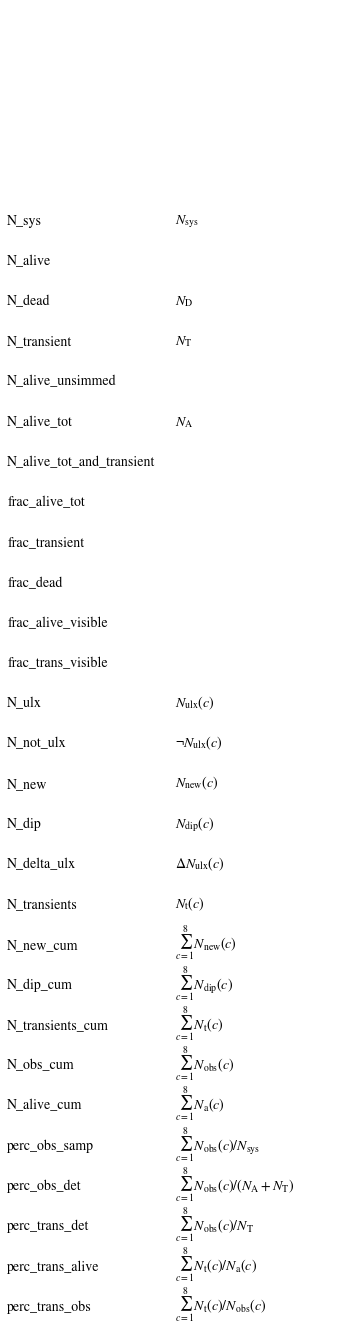

In [128]:
#Plot latex commands to see if they're working
fig = plt.figure()
plt.axis('off')
plt.xlim(0,10)
plt.ylim(0,10)

yval = 0
for k, v in latex.items():
    plt.text(x=0,y=yval, s=k, fontsize=14)
    plt.text(x=5,y=yval, s=v, fontsize=14)
    yval+=-1.85

1
2
3
4
5
6
7
8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


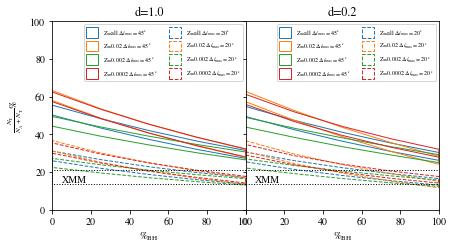

In [141]:
fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)
fig.set_size_inches([WIDTH,WIDTH/2])

plt.subplots_adjust(wspace=0)



ax[0].set_ylabel(r'$\frac{N_{\rm T}}{N_{\rm A} + N_{\rm T}} \times 100$')

colors = ['C0','C1','C2','C3', 'C0','C1','C2','C3']
linestyles = ['-', '-', '-', '-', '--','--','--', '--']



# Add Earnshaw XMM estimates

ax[0].axhspan(PERCENT_TRANS_EARNSHAW_LOWER, PERCENT_TRANS_EARNSHAW_UPPER, fill='', linestyle='dotted')
ax[0].text(x=5, y=PERCENT_TRANS_EARNSHAW-3, s='XMM', rotation=0)
ax[1].axhspan(PERCENT_TRANS_EARNSHAW_LOWER, PERCENT_TRANS_EARNSHAW_UPPER, fill='', linestyle='dotted')
ax[1].text(x=5, y=PERCENT_TRANS_EARNSHAW-3, s='XMM', rotation=0)


# Plot Data
j=0
for dincl in grid_mc['dincl_max']:
    for Z in grid_mc['Z']:
        for i, d in enumerate(grid_mc['duty_cycle']):
            sub = gb_counts.loc[10000,500,Z,:,dincl,'P_wind_days',d]
            sub = sub.reset_index()
            # plot_N_classification(sub)
            # plt_frac_classification(sub)
            var = 'frac_trans_visible'
            
            low = (sub[var]['mean'] - sub[var]['std']) * 100
            high = (sub[var]['mean'] + sub[var]['std']) * 100
            
            
            #ax[i].errorbar(y=sub['bh_ratio'], x=sub[var]['mean'], xerr=sub[var]['std'], linestyle='', label=f'dincl_max={dincl}')
            
            #ax[i].fill_betweenx(y=sub['bh_ratio']*100, x1=low, x2=high, alpha=0.8, facecolor='None', ec=colors[j], linestyle=linestyles[j], label=fr'Z={Z} $\Delta i_{{max}}=${dincl-1}$^{{\circ}}$')
            ax[i].fill_between(x=sub['bh_ratio']*100, y1=low, y2=high, alpha=1.0, facecolor='None', ec=colors[j], linestyle=linestyles[j], label=fr'Z={Z} $\Delta i_{{max}}=${dincl-1}$^{{\circ}}$')
            
            ax[i].set_title(f'd={d}')
            ax[i].set_xlim(0,100)
            ax[i].set_ylim(0,100)
            
            ax[i].set_xlabel(r'$\%_{\rm{BH}}$')
            ax[i].legend(prop={'size': 6}, ncol=2,handleheight=2.4)
        j+=1
        print(j)

plt.savefig('../reports/figures/bh_ratio_vs_transient_alive.png', dpi=1000)
plt.savefig('../reports/figures/bh_ratio_vs_transient_alive.eps', dpi=1000)
plt.savefig('../reports/figures/bh_ratio_vs_transient_alive.pdf', dpi=1000)


''

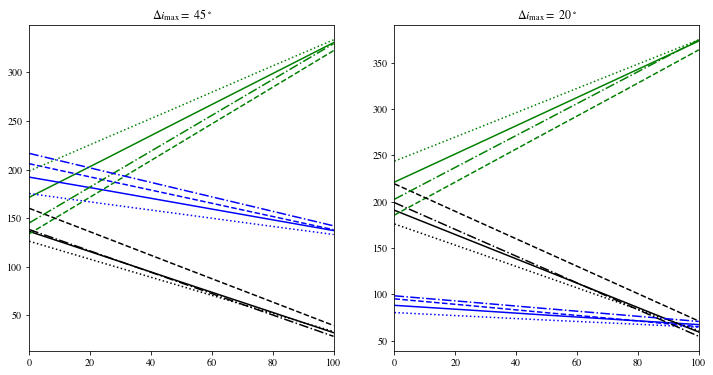

In [130]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ls = ['solid', 'dashed', 'dotted', 'dashdot']

for i, dincl in enumerate(grid_mc['dincl_max']):
    it = iter(colors)
    for j, Z in enumerate(grid_mc['Z']):
        
        sub = gb_counts.loc[10000,500,Z,:,dincl,'P_wind_days',1.0].reset_index()
        low_A  = sub['N_alive_tot']['mean'] - sub['N_alive_tot']['std']
        high_A = sub['N_alive_tot']['mean'] + sub['N_alive_tot']['std']

        low_T  = sub['N_transient']['mean'] - sub['N_transient']['std']
        high_T = sub['N_transient']['mean'] + sub['N_transient']['std']

        low_D  = sub['N_dead']['mean'] - sub['N_dead']['std']
        high_D = sub['N_dead']['mean'] + sub['N_dead']['std']

        ax[i].set_title(f'$\Delta i_{{\\rm max}} = $ {dincl-1}$^\\circ$')
        ax[i].set_xlim(0,100)
        ax[i].plot(sub['bh_ratio']*100, sub['N_alive_tot']['mean'], alpha=1.0, color='green', label='Alive', linestyle=ls[j])
        ax[i].plot(sub['bh_ratio']*100, sub['N_transient']['mean'], alpha=1.0, color='blue', label='Transient', linestyle=ls[j])
        ax[i].plot(sub['bh_ratio']*100, sub['N_dead']['mean'], alpha=1.0, color='black', label='Dead', linestyle=ls[j])

        
        #ax[i].fill_between(x=sub['bh_ratio']*100, y1=low_A, y2=high_A, alpha=1.0, facecolor='None', linestyle=ls, edgecolor='green', label='Alive')
        #ax[i].fill_between(x=sub['bh_ratio']*100, y1=low_T, y2=high_T, alpha=1.0, facecolor='None', linestyle=ls, edgecolor='blue', label='Transient')
        #ax[i].fill_between(x=sub['bh_ratio']*100, y1=low_D, y2=high_D, alpha=1.0, facecolor='None', linestyle=ls, edgecolor='black', label='Dead')

, 

In [131]:
j

3

In [132]:
def plot_erass_var(var):
    cycles = np.arange(1,9,1)
    colors = pl.cm.brg(np.linspace(0,1.0,5))
    colors = np.vstack([colors,colors])
    #colors = pl.cm.jet(np.linspace(0,1,3))
    #colors = np.append(colors, colors)
    colors = ['C0','C1','C2','C3','C4','C0','C1','C2','C3']
    linestyles = ['-', '-', '-', '-', '--','--','--', '--']
    
    duty_cycle = 1.0

    for Z in grid_mc['Z']:
        fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
        ax[0].set_ylabel(var)
        plt.subplots_adjust(wspace=0)
        for j, dincl in enumerate(grid_mc['dincl_max']):
            ax[j].set_title(f'Z={Z} $\Delta i _{{\\rm max }}$ = {dincl-1}$^{{\\circ}}$')
            for p in grid_mc['period']:
                it = iter(colors)
                it2 = iter(linestyles)
                for bh in grid_mc['bh_ratio']:
                    if bh in [0.25, 0.75]:
                        continue
                        
                    sub = df_res.loc[10000,500,Z,bh,dincl,p,duty_cycle].reset_index()

                    y = sub[var].mean()
                    arr = np.vstack(sub[var].values)
                    std = np.std(arr, axis=0)
                    low  = y - std 
                    high = y + std

                    if p == 'P_wind_days':
                        ls = '-'
                    else:
                        ls = '--'
                    ax[j].fill_between(x=cycles, y1=low, y2=high, alpha=0.7, facecolor='None', ec=next(it), ls=ls, label=f'{p} bh={bh}')
                        
                        
                    #ax[j].errorbar(x=cycles, y=y, yerr=std, linestyle='', label=f'{p} d={d}')
                    ax[j].set_xlim(1,8)
                    
                    ax[j].set_xlabel('eRASS Cycle')

                    #ax[j].plot(cycles, y, label=f'{p} d={d}')
                    ax[j].legend()

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


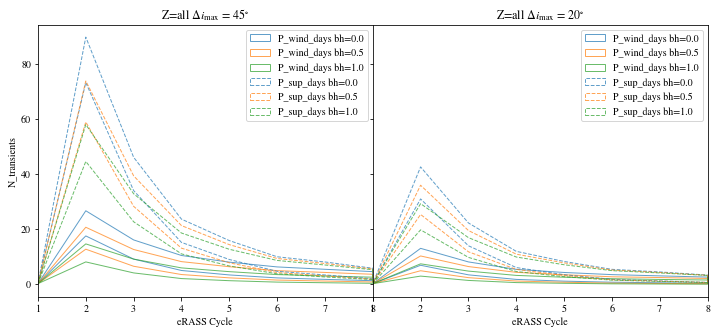

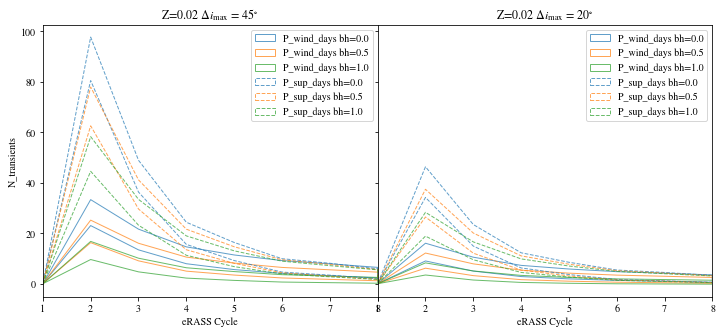

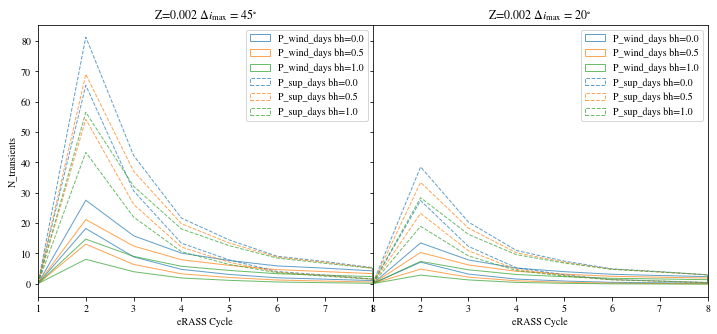

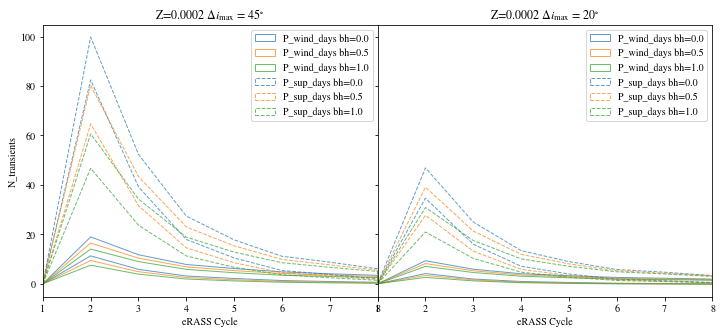

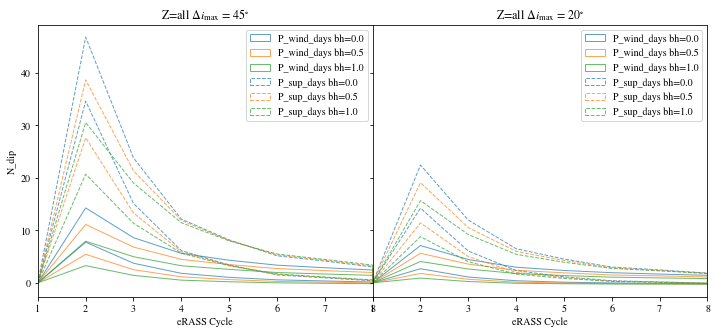

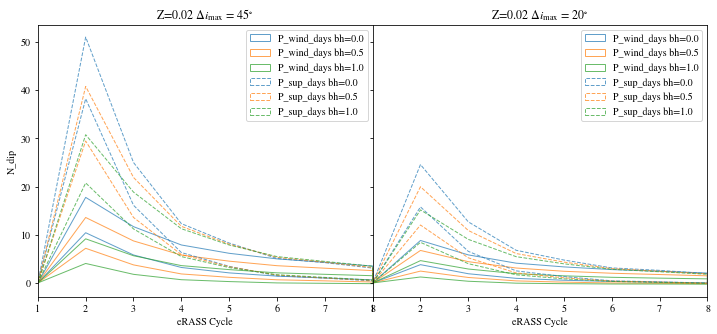

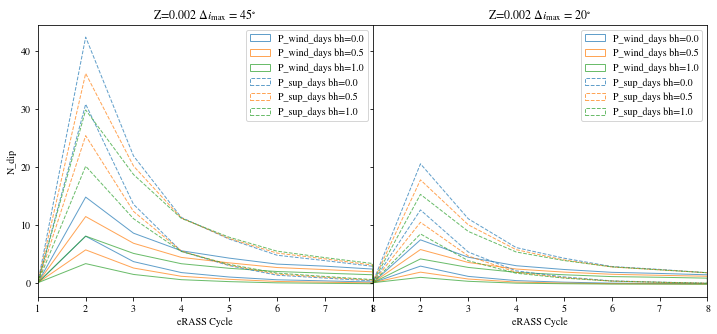

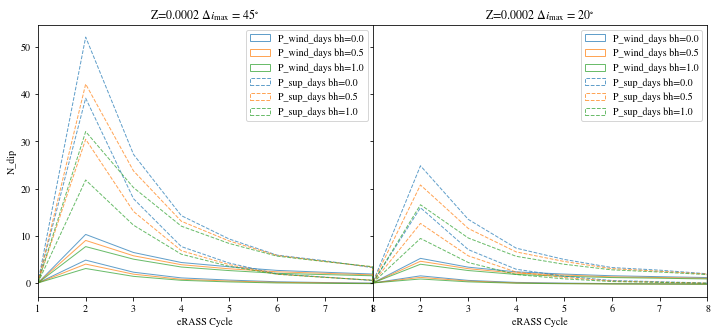

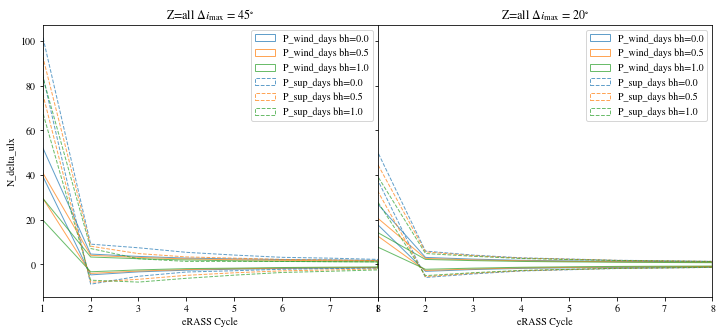

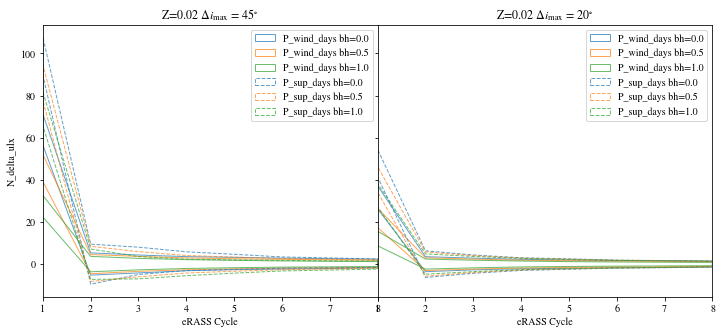

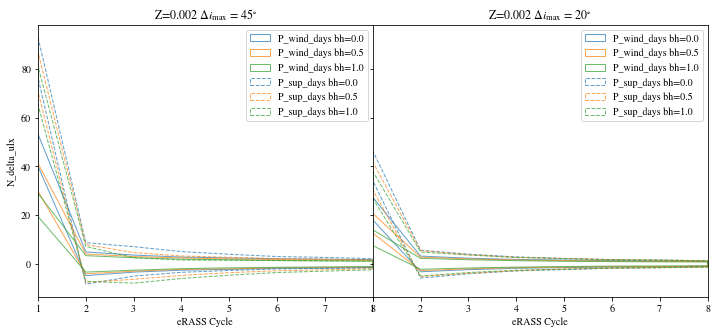

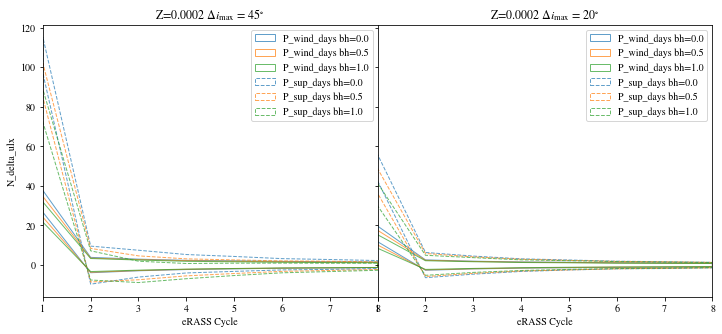

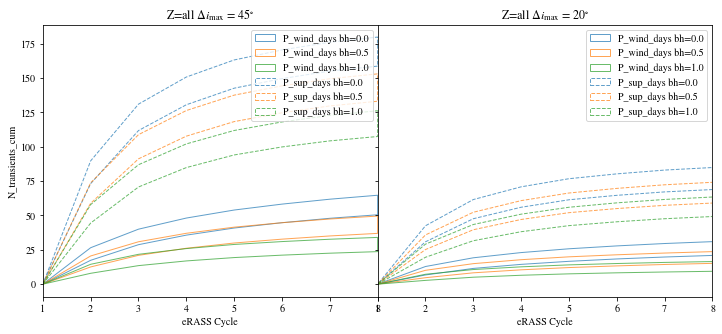

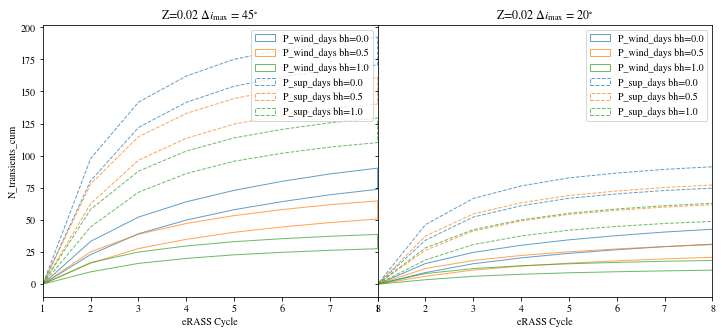

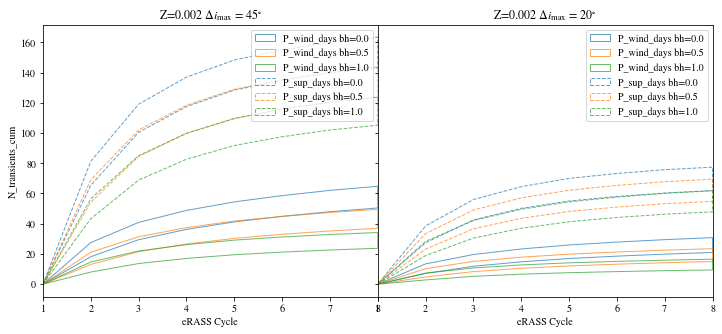

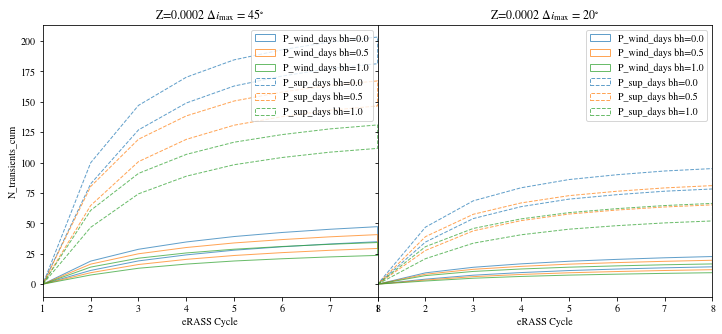

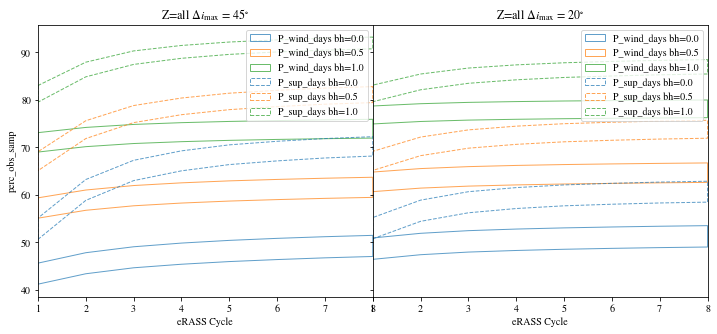

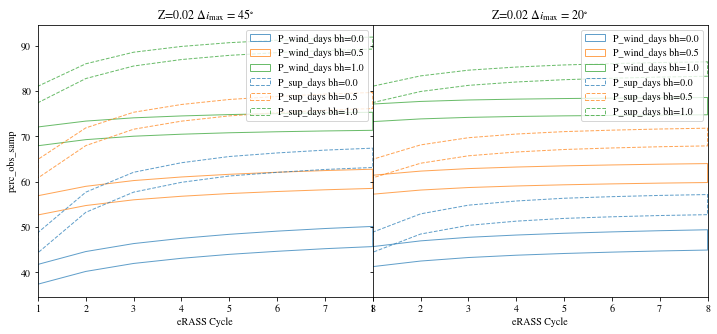

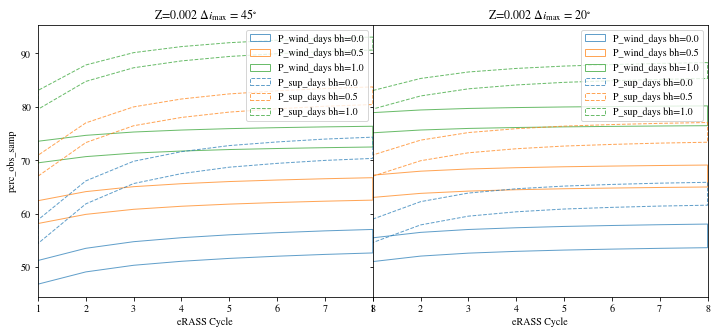

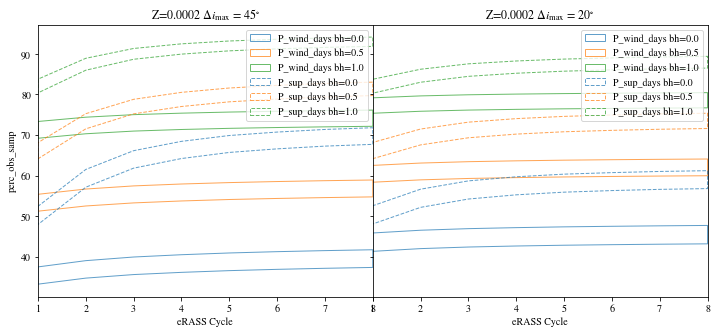

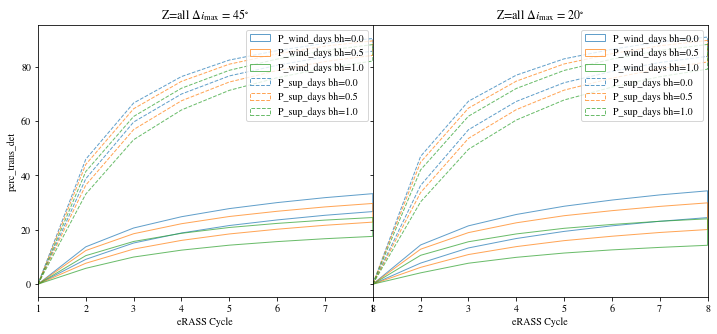

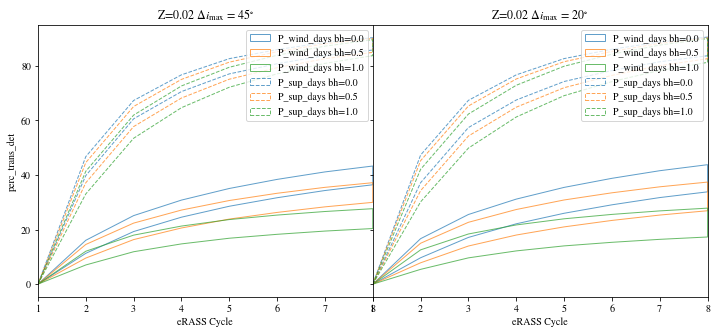

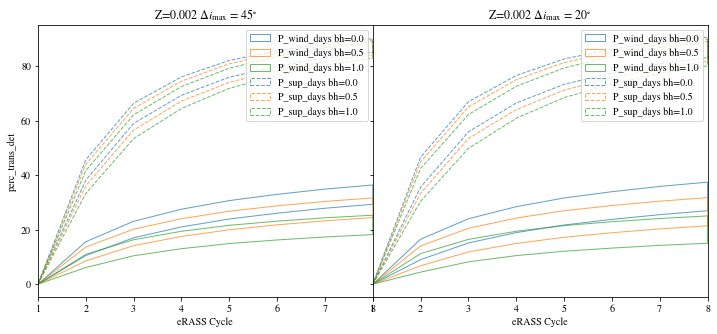

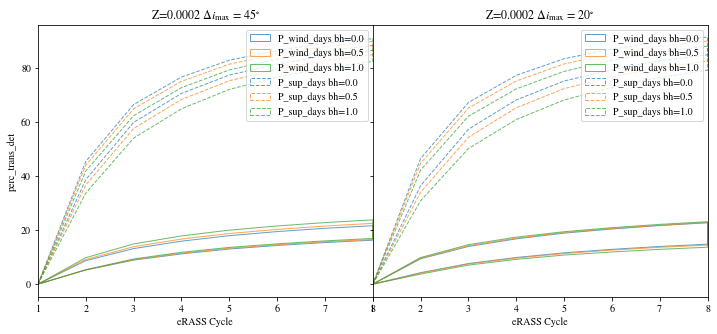

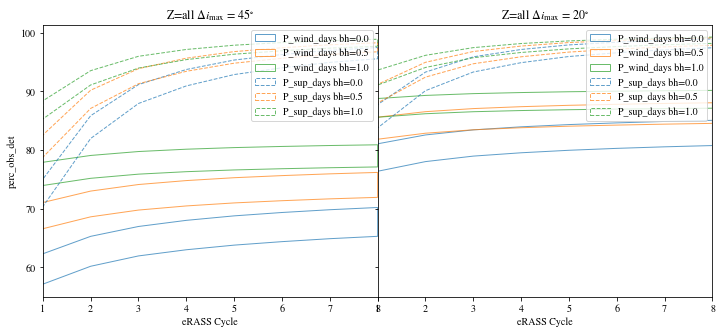

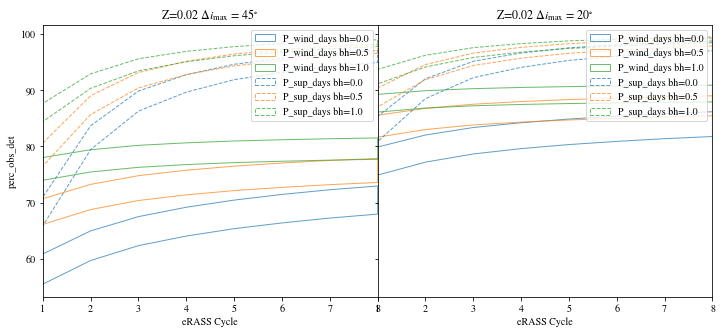

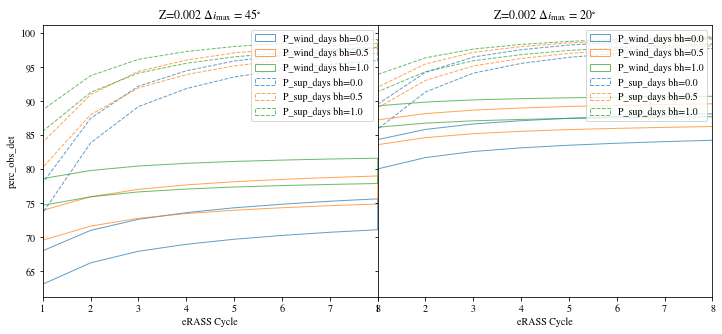

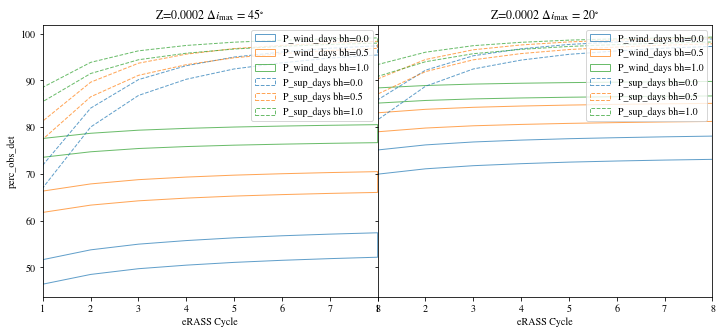

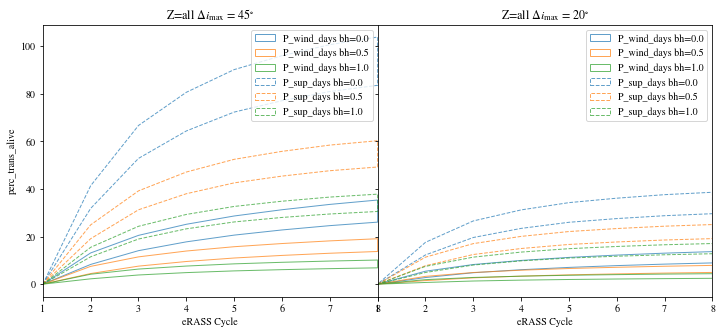

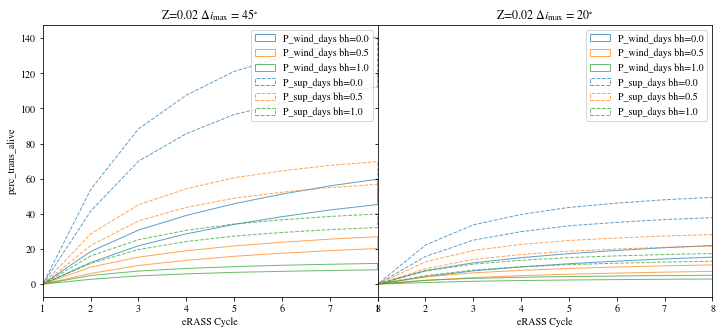

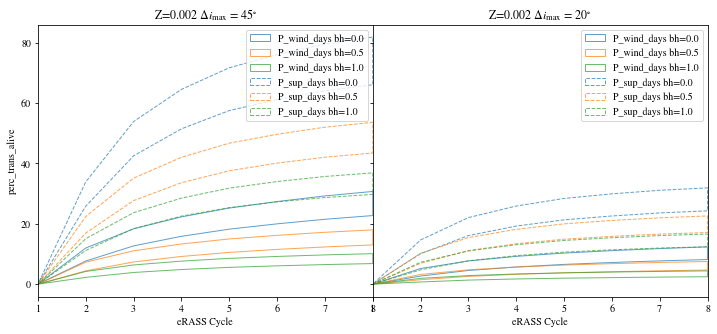

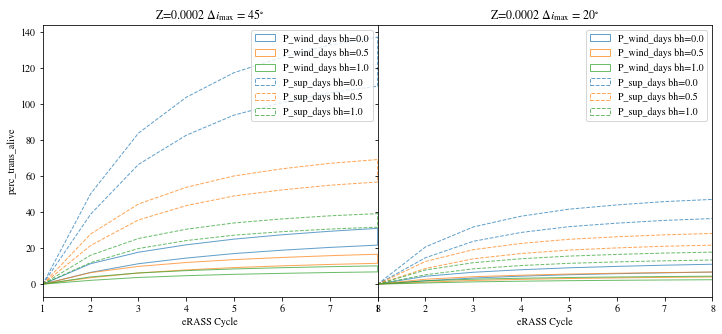

In [133]:
plot_erass_var('N_transients')
plot_erass_var('N_dip')
plot_erass_var('N_delta_ulx')
plot_erass_var('N_transients_cum')
plot_erass_var('perc_obs_samp')
plot_erass_var('perc_trans_det')
plot_erass_var('perc_obs_det')
plot_erass_var('perc_trans_alive')


In [134]:
def plot_erass_var2(var):
    P_dict = {'P_wind_days' : '$P_{{\\rm wind}}$',
              'P_sup_days' :  '$P_{{\\rm sup}}$'}
    
    cycles = np.arange(1,9,1)
    colors = pl.cm.brg(np.linspace(0,1.0,5))
    colors = np.vstack([colors,colors])
    #colors = pl.cm.jet(np.linspace(0,1,3))
    #colors = np.append(colors, colors)
    #colors = ['C0','C1','C2','C3','C4', 'C0','C1','C2','C3']
    linestyles = ['-', '-', '-', '-', '--','--','--', '--']
    
    duty_cycle = 1.0

    
    for Z in grid_mc['Z']:
        fig, ax = plt.subplots(2,2, figsize=(12,12), sharey=False)
        ax[0][0].set_ylabel(var)
        ax[1][0].set_ylabel(var)    
        #plt.subplots_adjust(wspace=0)
        for j, dincl in enumerate(grid_mc['dincl_max']):
            for i, p in enumerate(grid_mc['period']):
                ax[j][i].set_title(f'Z={Z} $\Delta i _{{\\rm max }}$ = {dincl-1}$^{{\\circ}}$ {P_dict[p]}')
                it = iter(colors)
                for bh in grid_mc['bh_ratio']:
                    
                    sub = df_res.loc[10000,500,Z,bh,dincl,p,duty_cycle].reset_index()

                    y = sub[var].mean()
                    arr = np.vstack(sub[var].values)
                    std = np.std(arr, axis=0)
                    low  = y - std 
                    high = y + std

                    if p == 'P_wind_days':
                        ls = '-'
                    else:
                        ls = '--'

                    ax[j][i].fill_between(x=cycles, y1=low, y2=high, alpha=0.7, facecolor='None', ec=next(it), label=f'$\%_{{\\rm BH}}$={bh}')
                    #ax[j].errorbar(x=cycles, y=y, yerr=std, linestyle='', label=f'{p} d={d}')
                    ax[j][i].set_xlim(1,8)
                    
                    ax[j][i].set_xlabel('eRASS Cycle')

                    #ax[j].plot(cycles, y, label=f'{p} d={d}')
                    ax[j][i].legend()
                    
        #plt.savefig(f'../reports/figures/erass_Z={Z}_{var}.png',dpi=1000)
        #plt.savefig(f'../reports/figures/erass_Z={Z}_{var}.eps')
        #plt.savefig(f'../reports/figures/erass_Z={Z}_{var}.pdf')

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


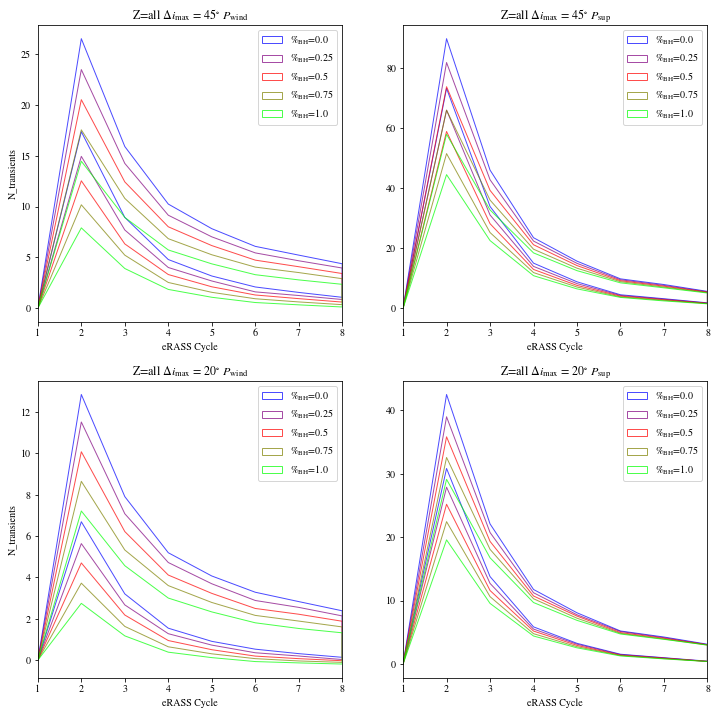

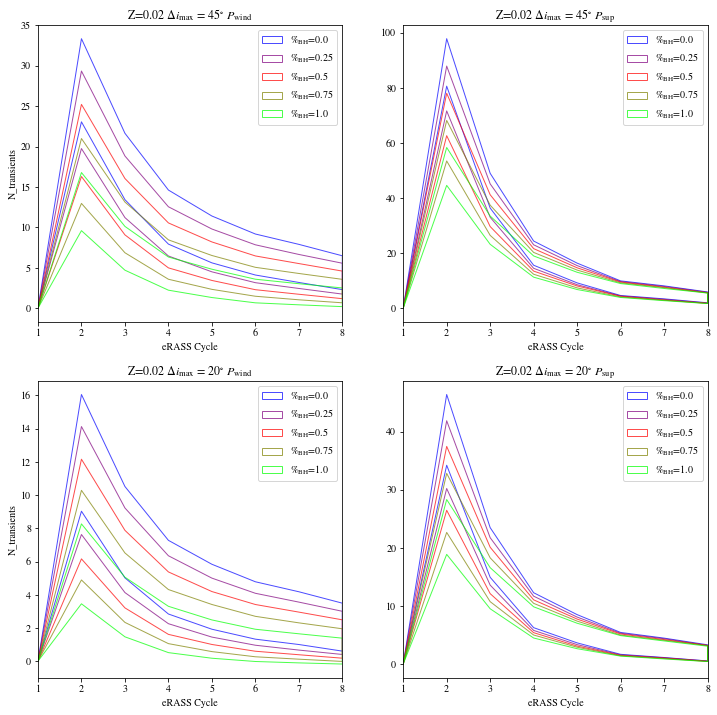

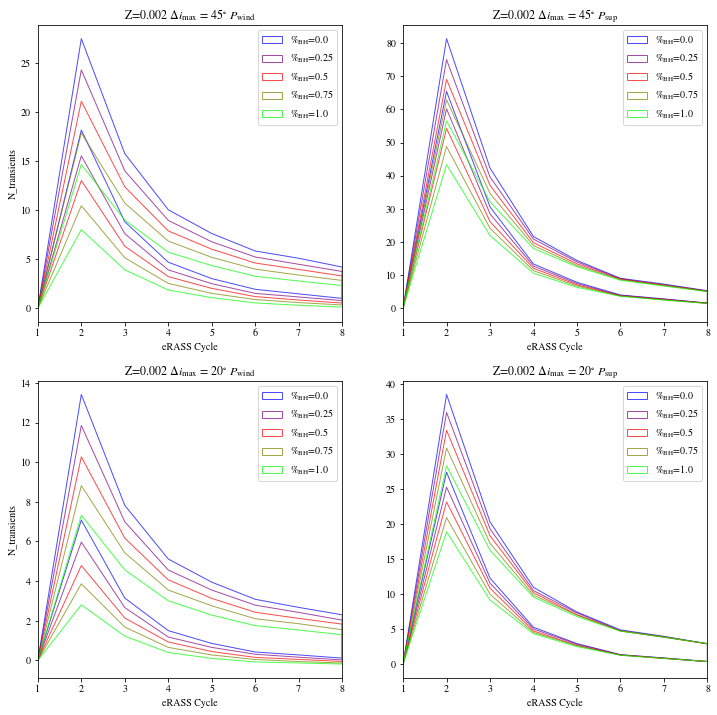

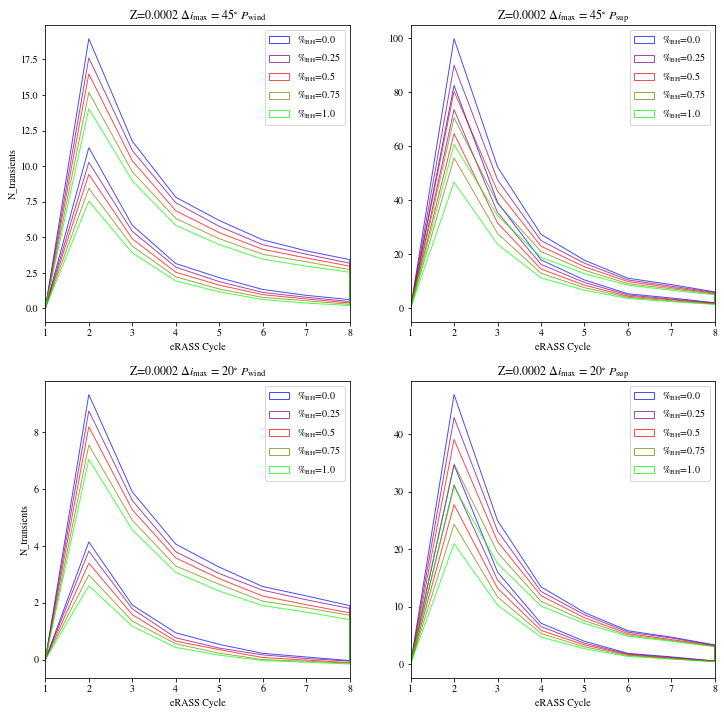

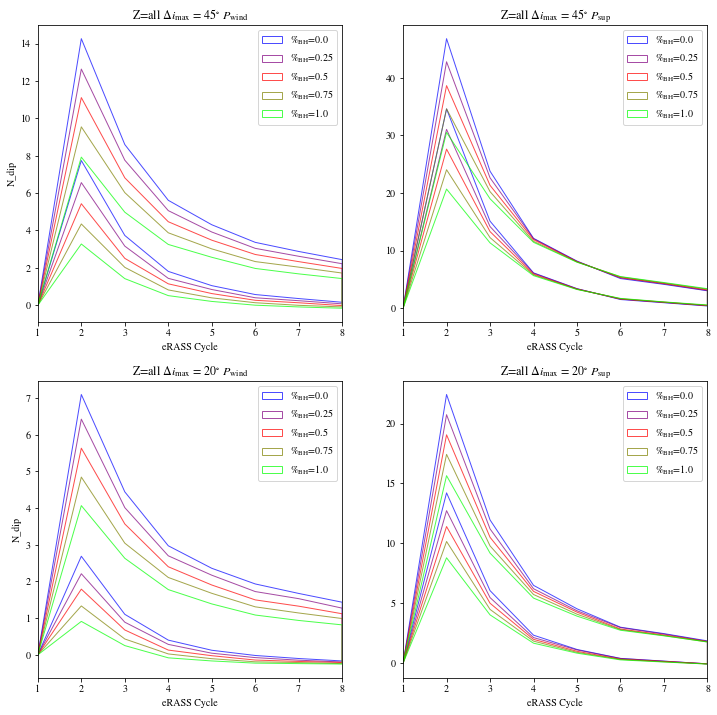

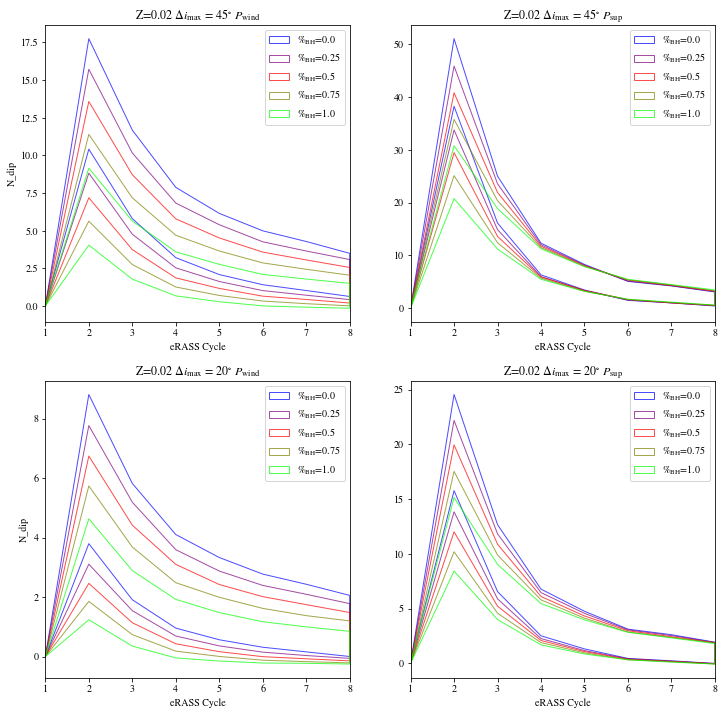

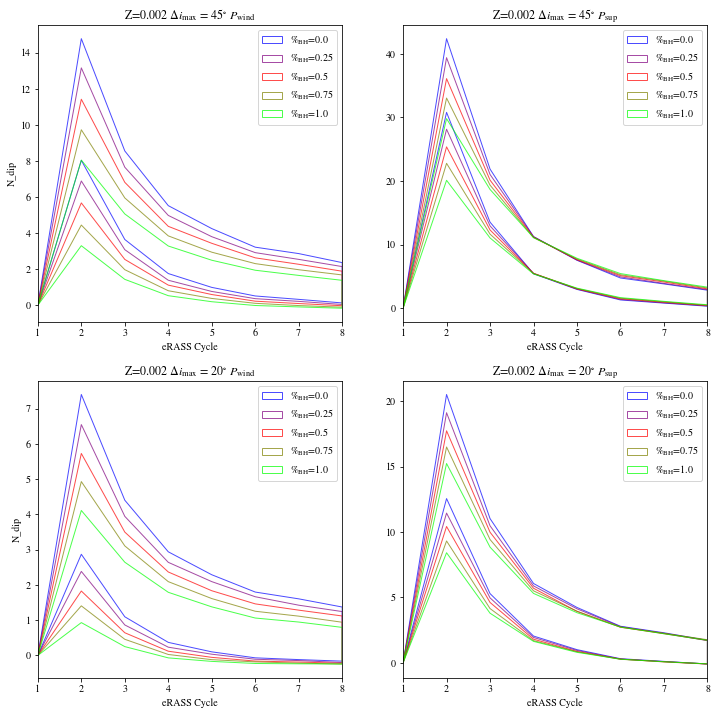

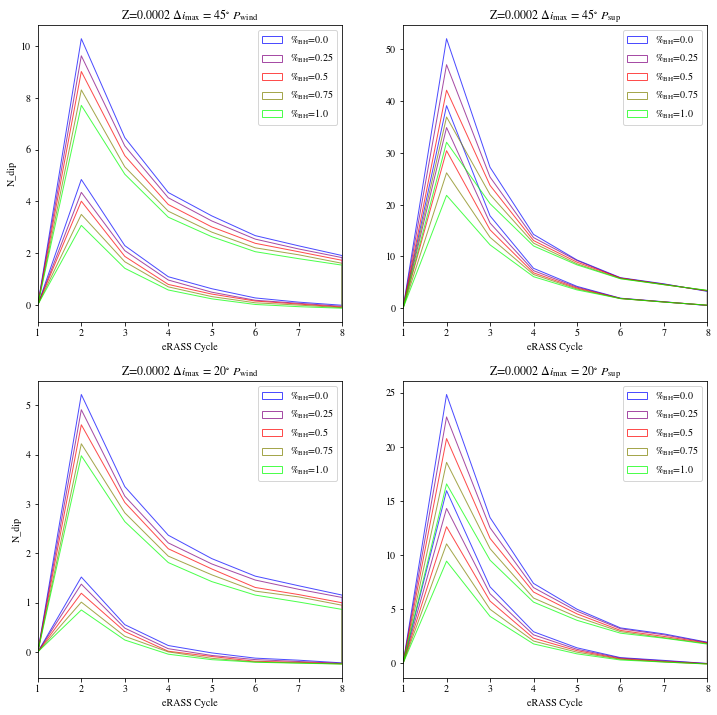

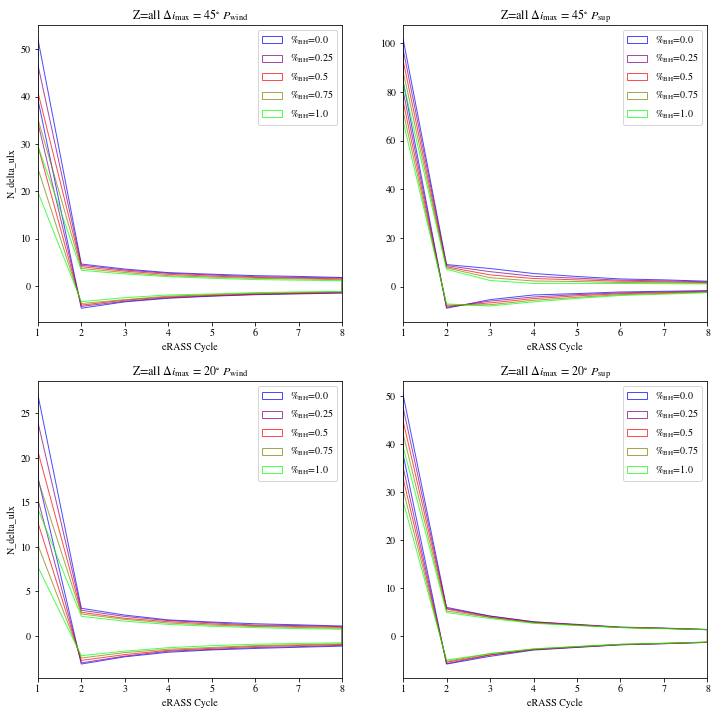

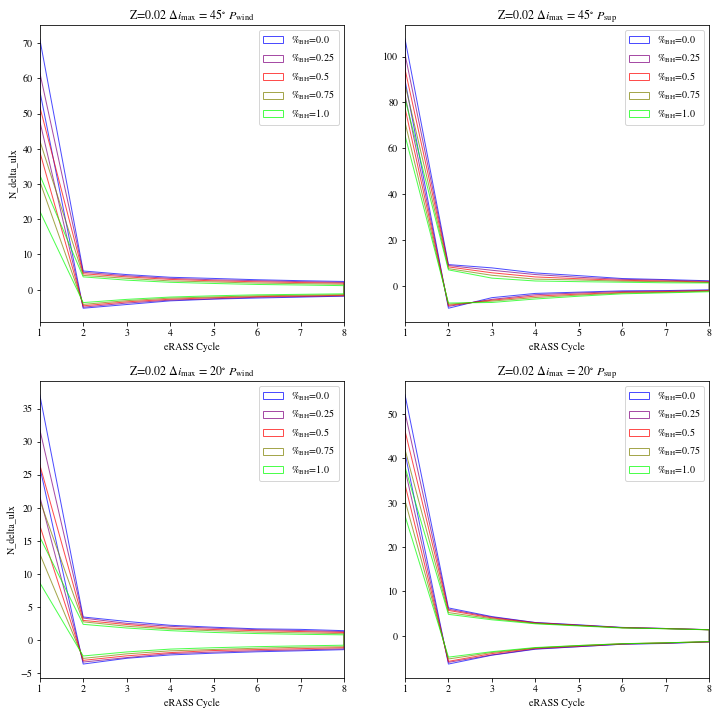

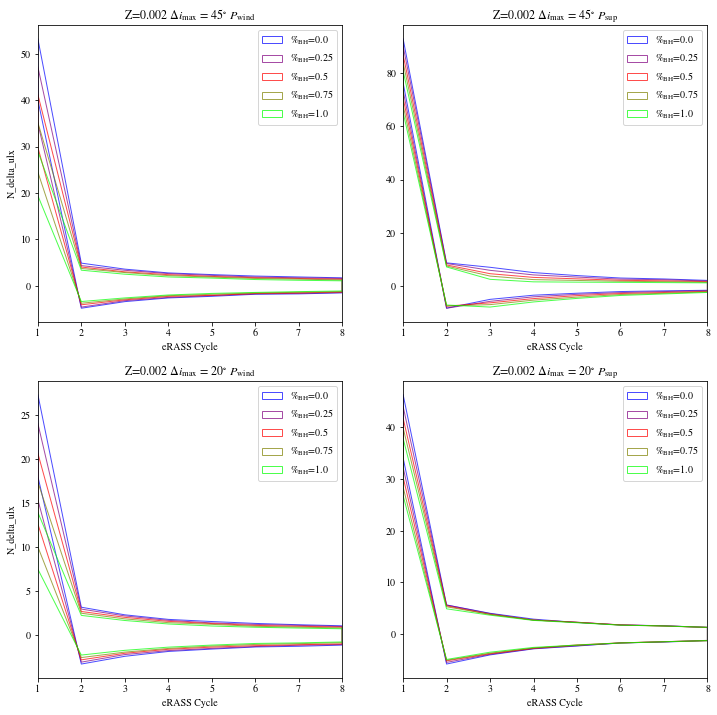

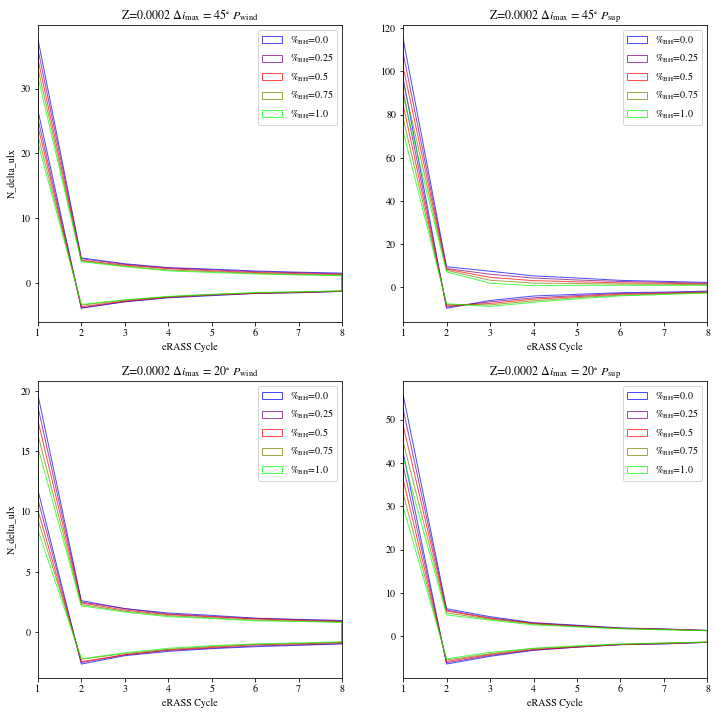

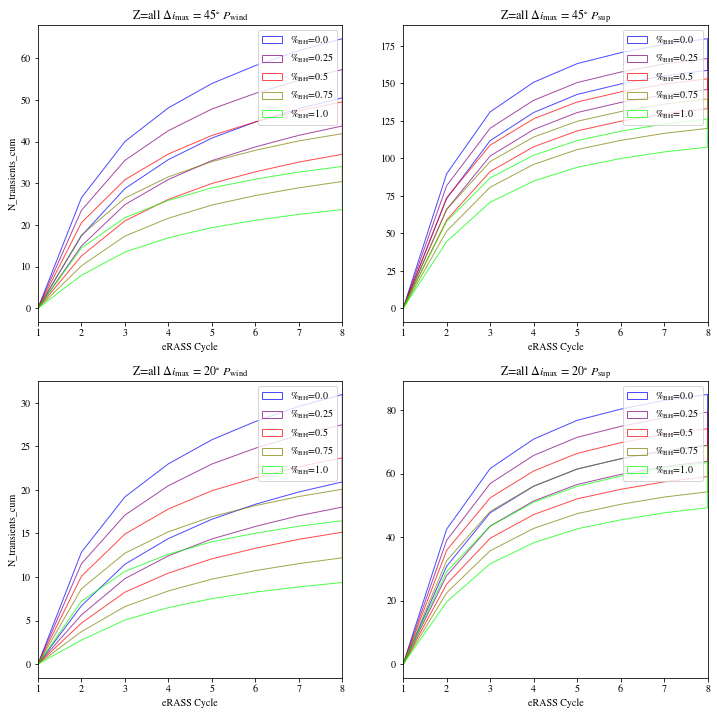

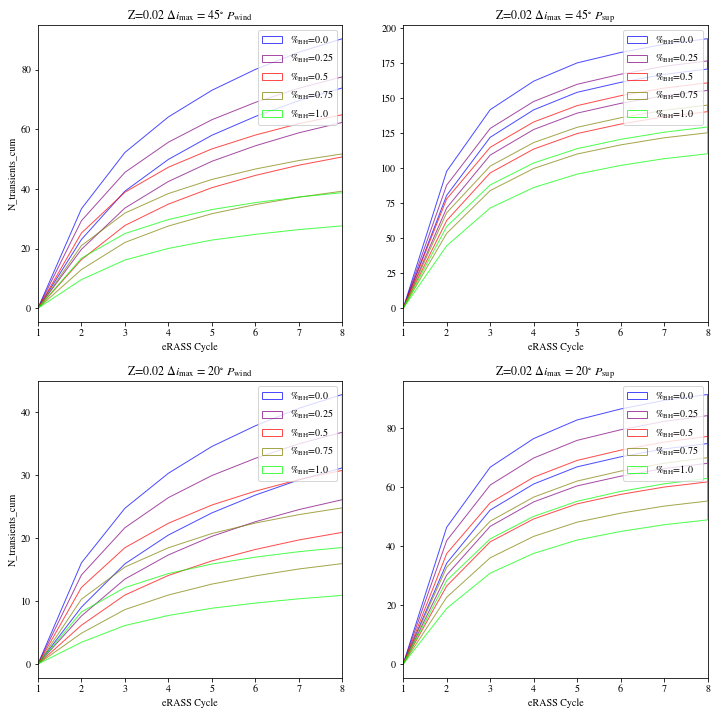

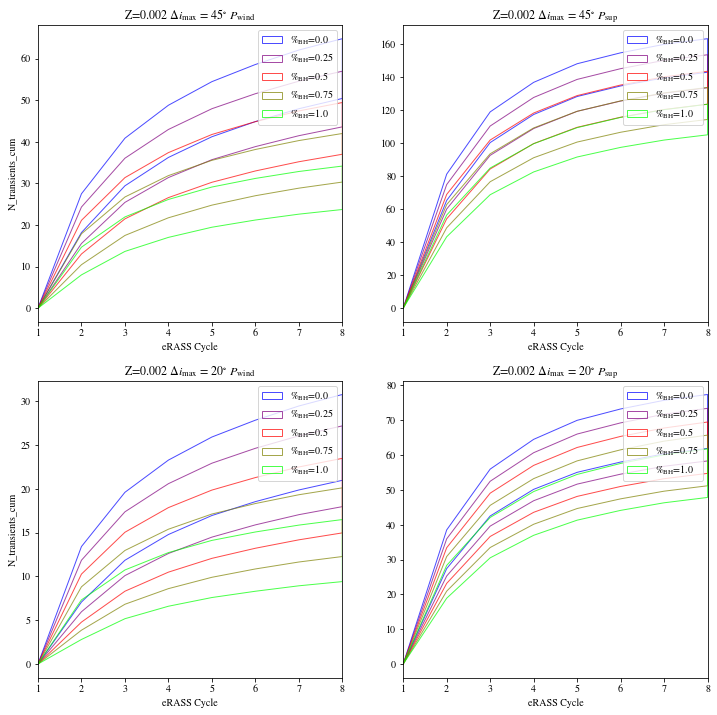

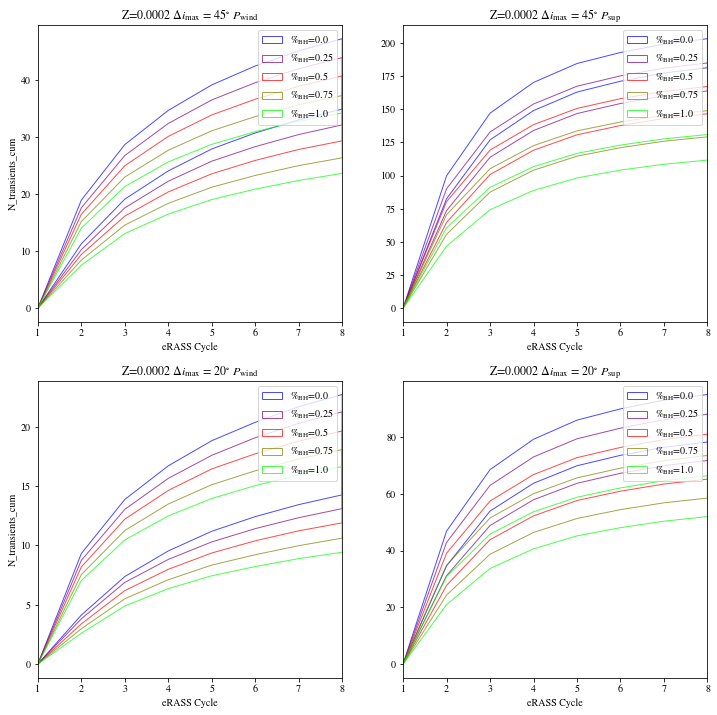

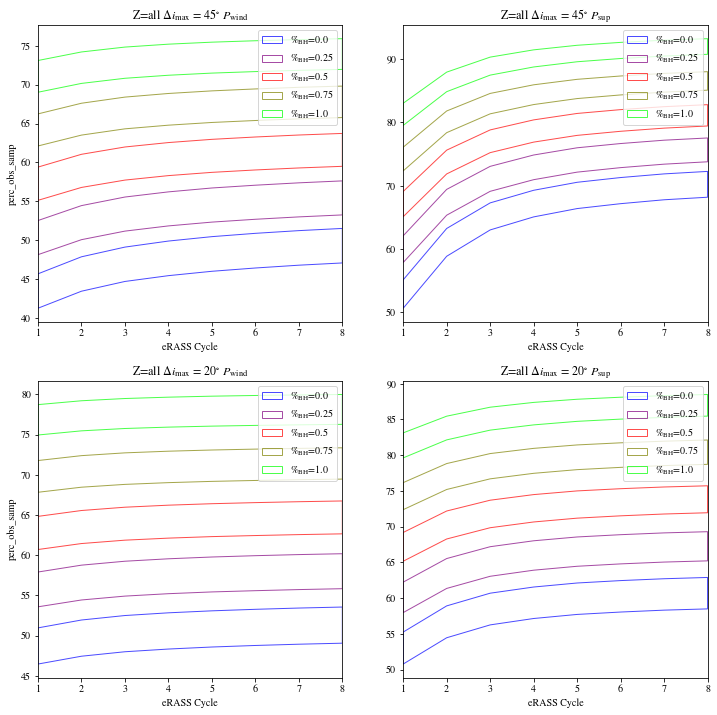

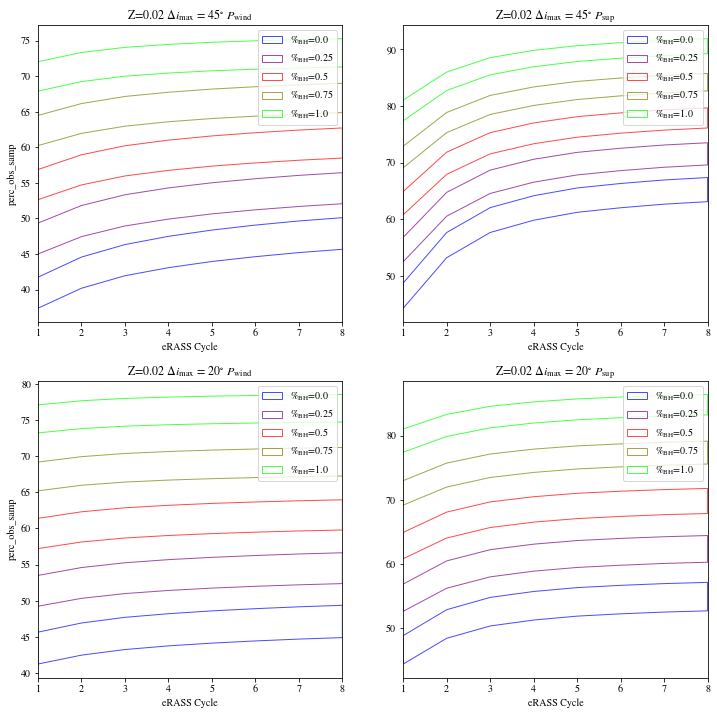

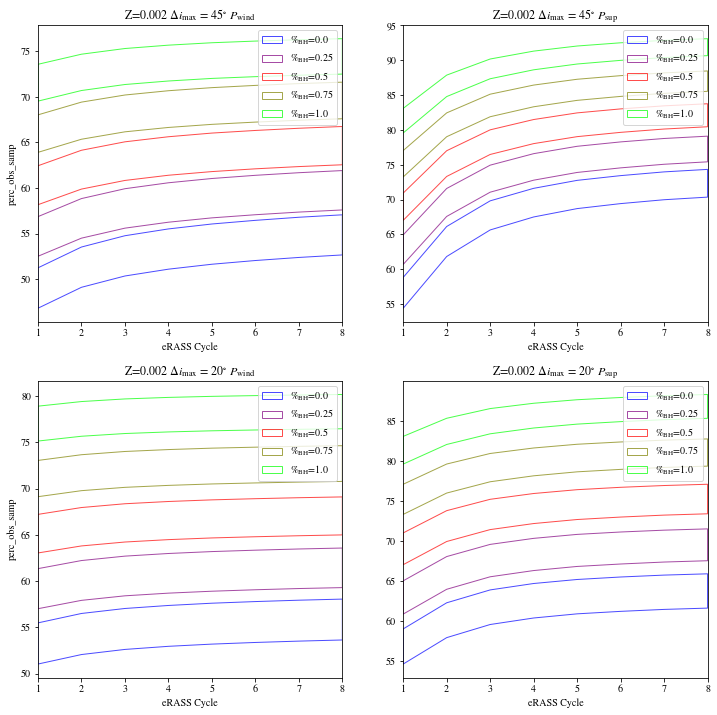

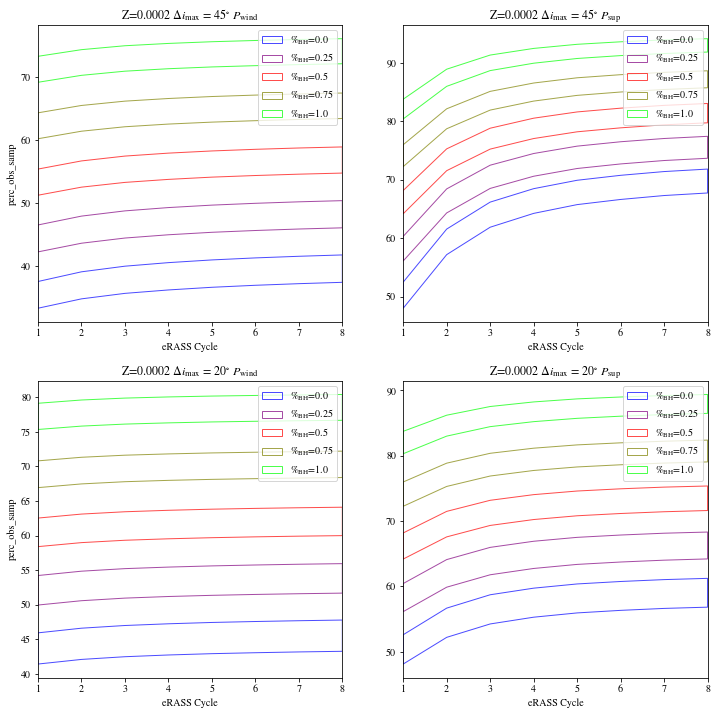

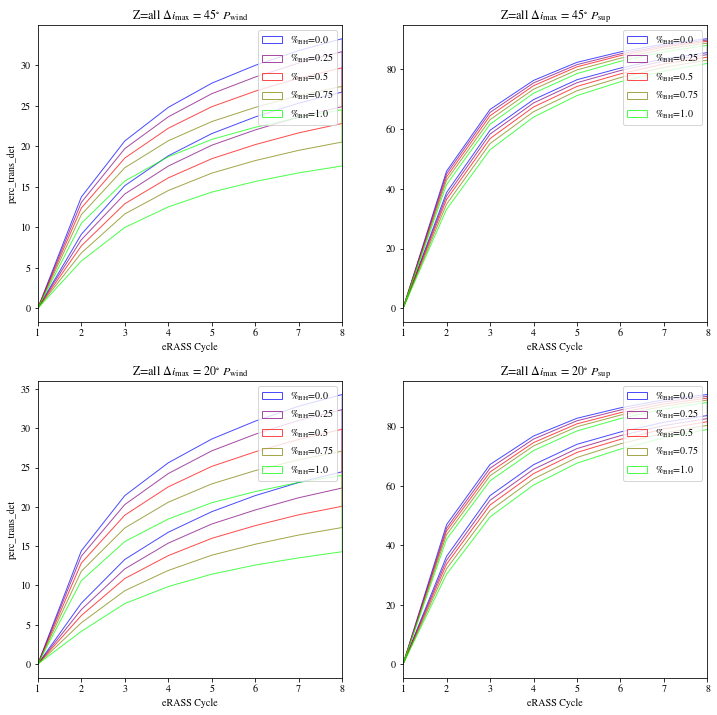

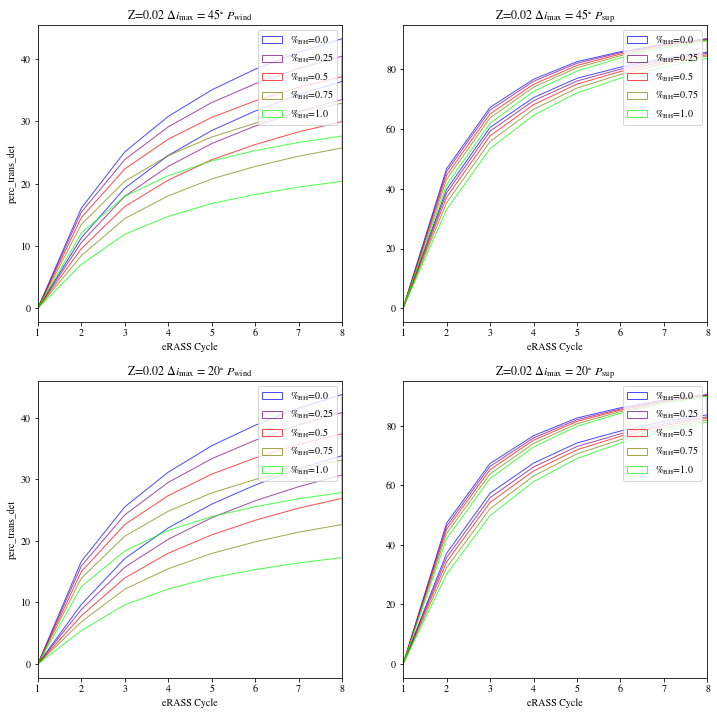

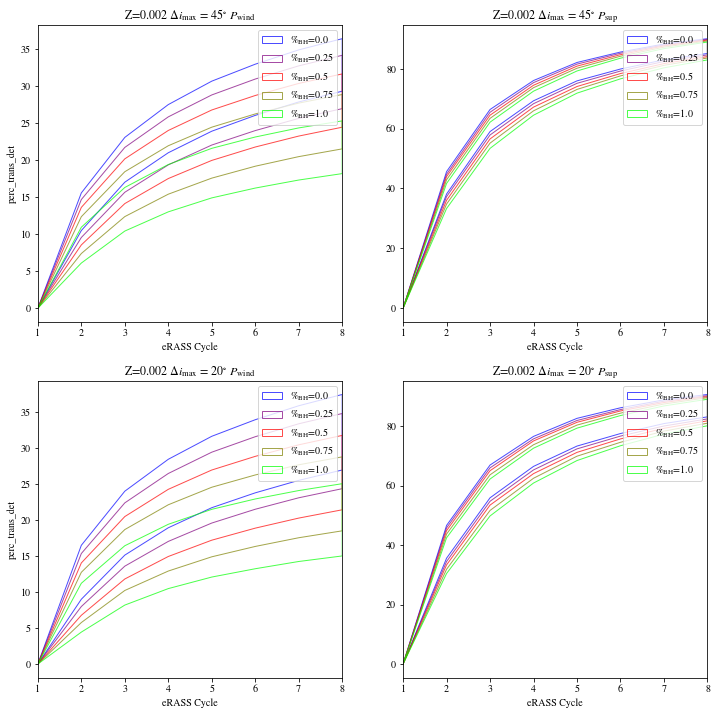

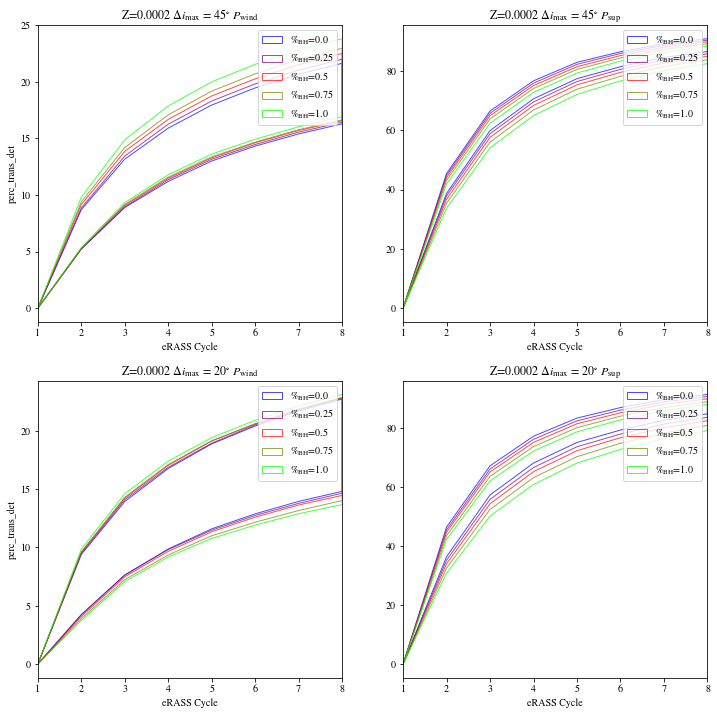

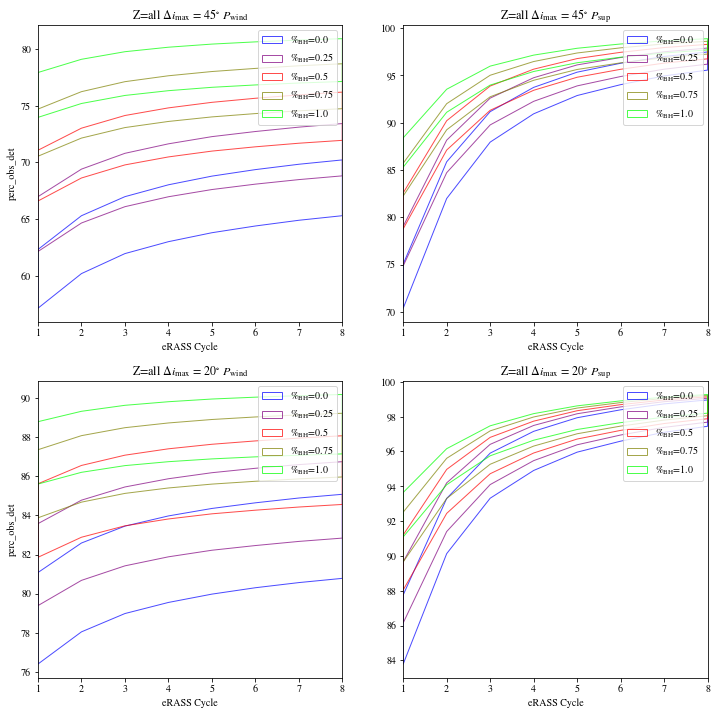

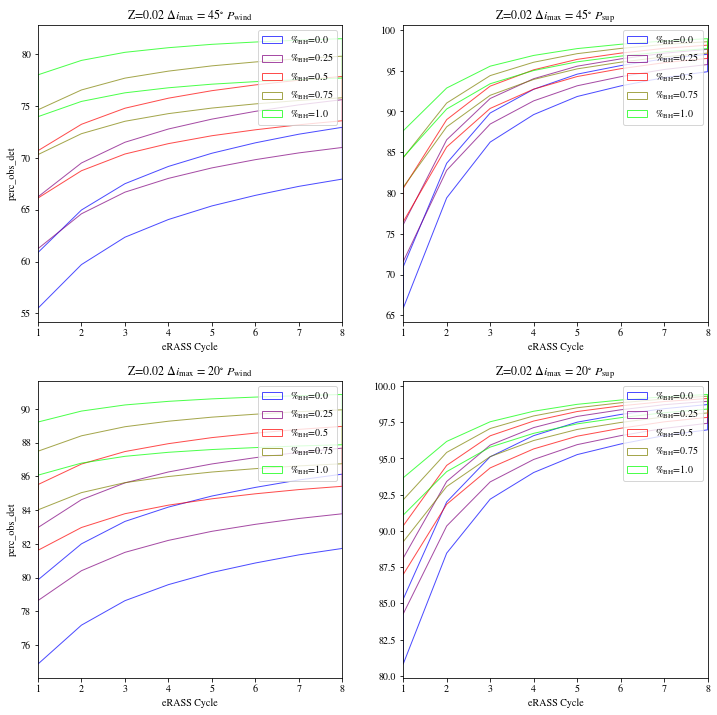

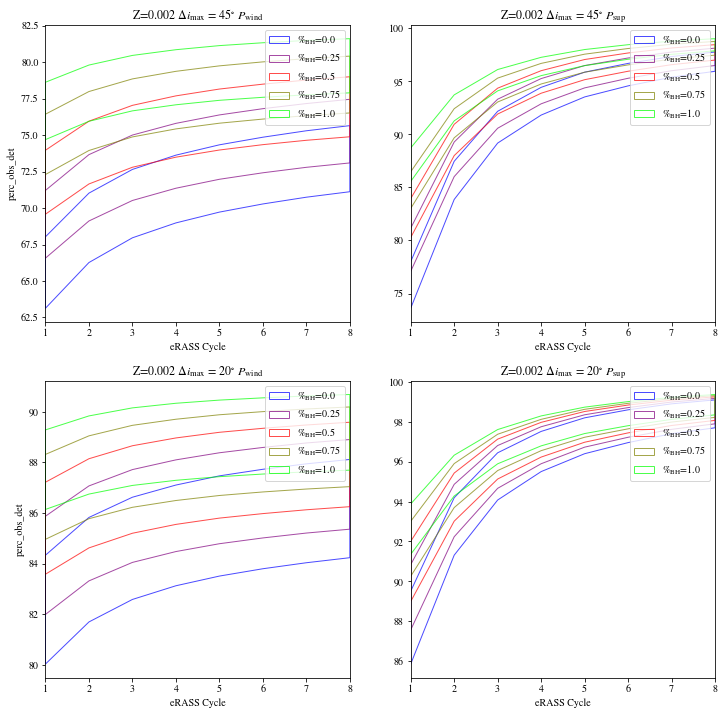

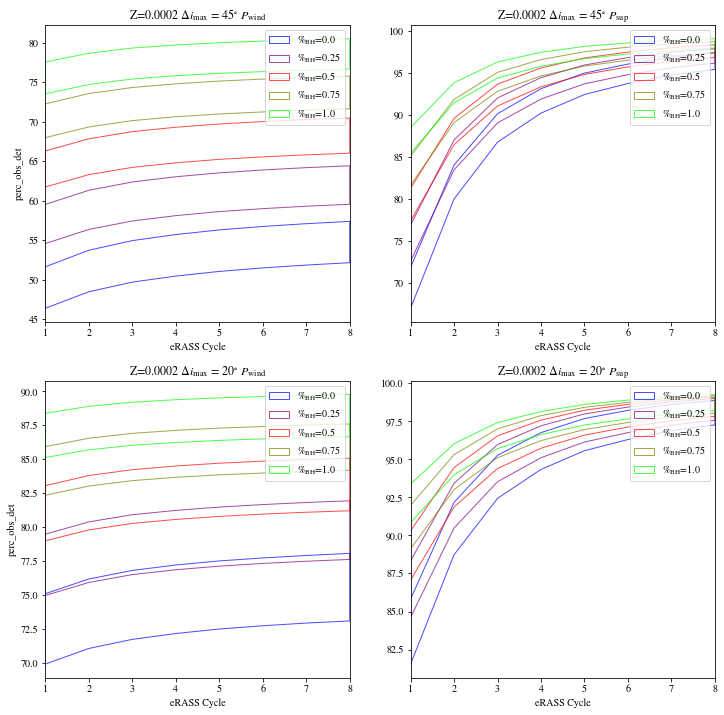

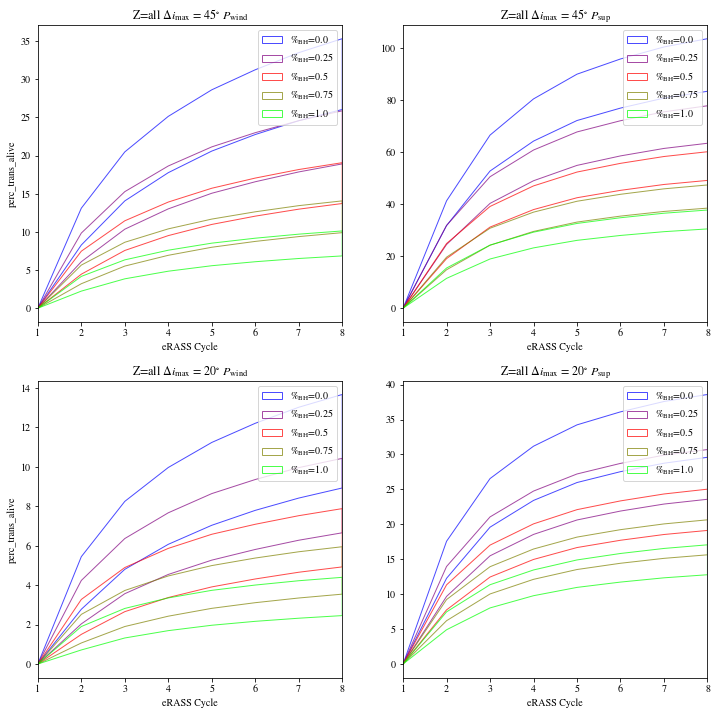

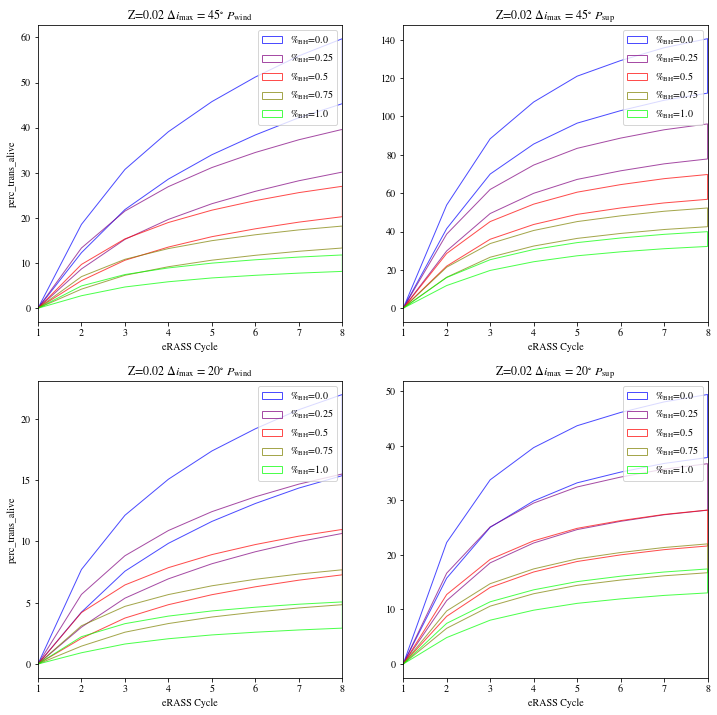

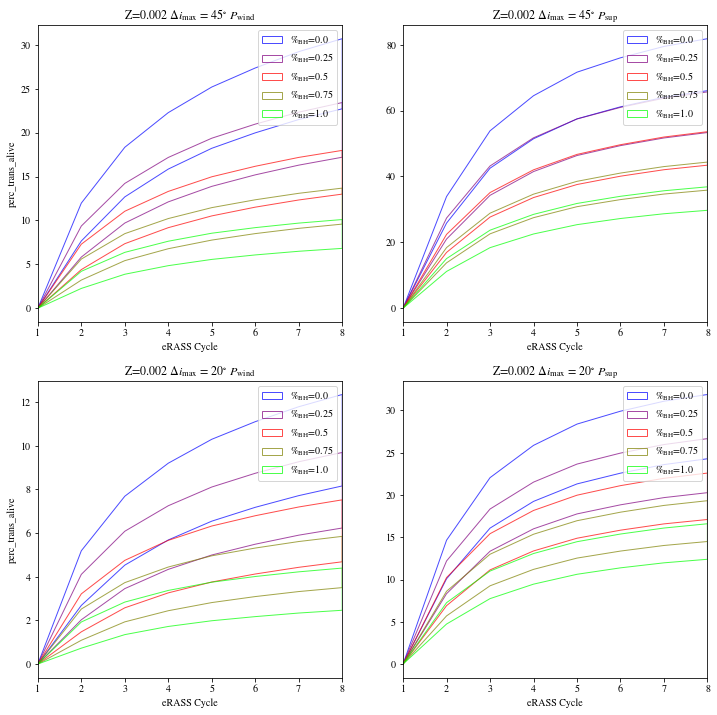

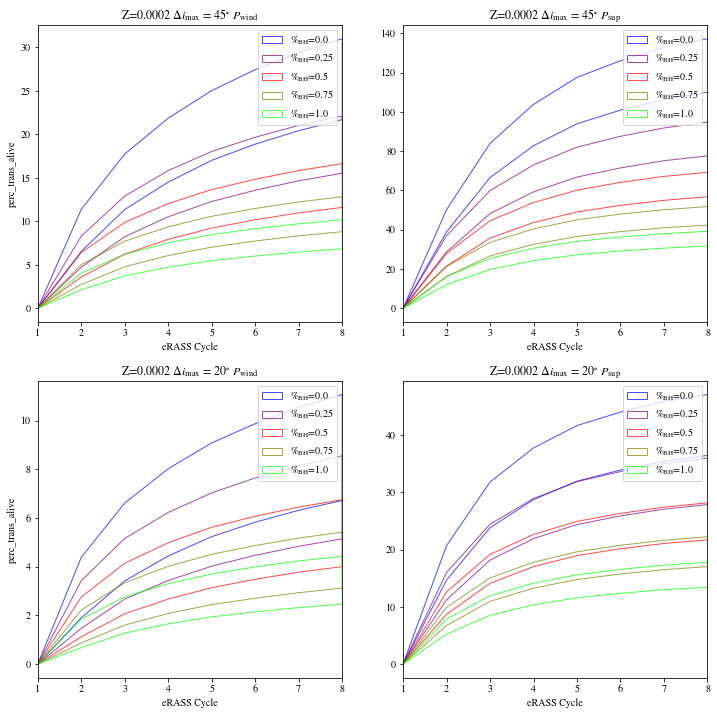

In [135]:
plot_erass_var2('N_transients')
plot_erass_var2('N_dip')
plot_erass_var2('N_delta_ulx')
plot_erass_var2('N_transients_cum')
plot_erass_var2('perc_obs_samp')
plot_erass_var2('perc_trans_det')
plot_erass_var2('perc_obs_det')
plot_erass_var2('perc_trans_alive')

In [139]:
def plot_erass_var3(var):
    P_dict = {'P_wind_days' : '$P_{{\\rm wind}}$',
              'P_sup_days' :  '$P_{{\\rm sup}}$'}
    
    cycles = np.arange(1,9,1)
    #colors = pl.cm.brg(np.linspace(0,1.0,5))
    #colors = np.vstack([colors,colors])
    
    #colors = np.append(colors, colors)
    colors = ['C0','C1','C2','C3','C4', 'C0','C1','C2','C3']
    #linestyles = ['-', '-', '-', '-', '--','--','--', '--']
    
    duty_cycle = 1.0

    Z = 'all'
    dincl = 46
    p = 'P_sup_days'
    

    fig, ax = plt.subplots(1,1, figsize=(6,6), sharey=False)
    fig.set_size_inches([WIDTH_HALF, WIDTH_HALF])
    
    ax.set_xticks(cycles)
    ax.set_ylabel(latex[var])
        
    #plt.subplots_adjust(wspace=0)
    ax.set_title(f'Z={Z} $\Delta i _{{\\rm max }}$ = {dincl-1}$^{{\\circ}}$ {P_dict[p]}')
    it = iter(colors)
    for bh in grid_mc['bh_ratio']:

        sub = df_res.loc[10000,500,Z,bh,dincl,p,duty_cycle].reset_index()

        y = sub[var].mean()
        arr = np.vstack(sub[var].values)
        std = np.std(arr, axis=0)
        low  = y - std 
        high = y + std

        if p == 'P_wind_days':
            ls = '-'
        else:
            ls = '--'

        ax.fill_between(x=cycles, y1=low, y2=high, alpha=0.7, facecolor=next(it), ec='black', label=f'$\%_{{\\rm BH}}$={bh}')
        #ax[j].errorbar(x=cycles, y=y, yerr=std, linestyle='', label=f'{p} d={d}')
        ax.set_xlim(1,8)

    ax.set_xlabel('eRASS Cycle')

        #ax[j].plot(cycles, y, label=f'{p} d={d}')
    ax.legend(loc='upper left', prop={'size': 6})

    filename = f'erass-Z={Z}-dincl={dincl}-P={p}-{var}'
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{filename}.png',dpi=1000)
    plt.savefig(f'../reports/figures/{filename}.eps')
    plt.savefig(f'../reports/figures/{filename}.pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

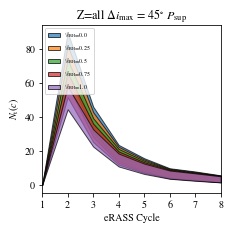

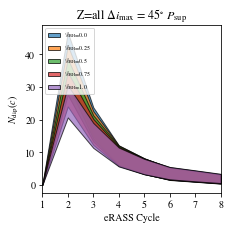

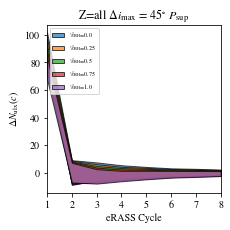

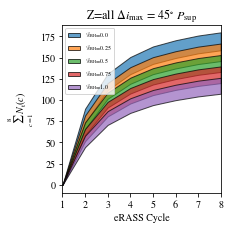

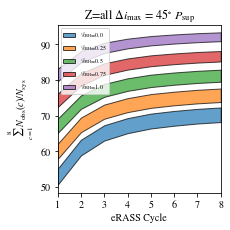

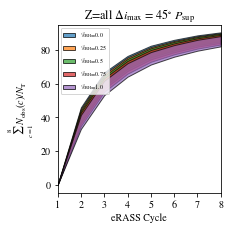

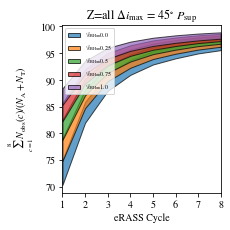

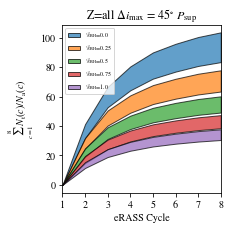

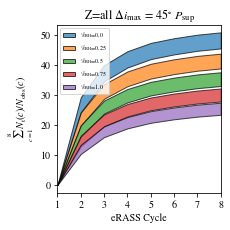

In [140]:
plot_erass_var3('N_transients')
plot_erass_var3('N_dip')
plot_erass_var3('N_delta_ulx')
plot_erass_var3('N_transients_cum')
plot_erass_var3('perc_obs_samp')
plot_erass_var3('perc_trans_det')
plot_erass_var3('perc_obs_det')
plot_erass_var3('perc_trans_alive')
plot_erass_var3('perc_trans_obs')